In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandahouse
import pandas as pd
from causalimpact import CausalImpact

2024-04-10 20:21:58.757827: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 20:21:58.819105: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 20:21:58.819854: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 20:22:00.017634: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
connection = {'host': '*',
'database':'*',
'user':'*',
'password':'*'
}
start_date = '2024-03-15'
end_date = '2024-03-21'

In [3]:
#CTR
q_CTR = f'''
SELECT toStartOfHour(toDateTime(time)) as time,
       countIf(action = 'like') / countIf(action = 'view') AS CTR
FROM simulator_20240320.feed_actions
WHERE toDate(time) <= '{end_date}'
GROUP BY time
ORDER BY time
'''
#likes_per_user
q_lpu = f'''
select toStartOfHour(toDateTime(time)) as time,
countIf(action = 'like') / count(distinct user_id) as likes_per_user
from simulator_20240320.feed_actions
WHERE toDate(time) <= '{end_date}'
GROUP BY time
ORDER BY time
'''
#views_per_user
q_vpu = f'''
select toStartOfHour(toDateTime(time)) as time,
countIf(action = 'view') / count(distinct user_id) as views_per_user
from simulator_20240320.feed_actions
WHERE toDate(time) <= '{end_date}'
GROUP BY time
ORDER BY time
'''
#posts_per_user
q_ppu = f'''
select toStartOfHour(toDateTime(time)) as time,
count(distinct post_id) / count(distinct user_id) as posts_per_user
from simulator_20240320.feed_actions
WHERE toDate(time) <= '{end_date}'
GROUP BY time
ORDER BY time
'''
#stickiness
q_stck = f'''
with daily_users AS (
SELECT
    count(DISTINCT user_id) as users_dau,
    time::date as time
  FROM
    simulator_20240320.feed_actions full join simulator_20240320.message_actions using user_id
  WHERE
    time >= toDate('{end_date}') - INTERVAL '30 day' and time <= toDate('{end_date}')
  group by time
),
monthly_users AS (
  SELECT
    count(DISTINCT user_id) as users_mau
  FROM
    simulator_20240320.feed_actions full join simulator_20240320.message_actions using user_id
  WHERE
    time >= toDate('{end_date}') - INTERVAL '30 day' and time <= toDate('{end_date}')
)
SELECT
time,
  daily_users.users_dau / monthly_users.users_mau
FROM
  daily_users,
  monthly_users
'''
metrics = {
    'CTR': q_CTR,
    'likes per user': q_lpu,
    'views per user': q_vpu,
    'posts per user': q_ppu,
    'stickiness': q_stck
}

In [4]:
def get_causal_effect(query, start_date):
    df = pandahouse.read_clickhouse(query, connection=connection)
    start_date = pd.Timestamp(start_date)
    start_idx = (df['time'] == start_date).idxmax()
    pre_period = [0, start_idx]
    post_period = [start_idx + 1, len(df) - 1]
    df = df.drop('time', axis = 1)
    impact = CausalImpact(data = df, #данные
                      pre_period = pre_period, #период до события
                      post_period = post_period, #период после события
                      )
    impact.plot()
    print(impact.summary())
    print(impact.summary('report').rsplit("\n\n\n", 1)[-1])

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2024-04-10 20:22:08.251401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2024-04-10 20:22:08.251732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2024-04-10 20:22:08.262347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2024-04-10 20:22:08.262606: I tens

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


2024-04-10 20:22:09.360298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-04-10 20:22:09.384666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_1_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-04-10 20:22:09.419012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node monte_carlo_variational_loss/expectation/powerInv

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


2024-04-10 20:23:37.392214: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 394000000 exceeds 10% of free system memory.
2024-04-10 20:23:38.560568: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 394000000 exceeds 10% of free system memory.
2024-04-10 20:23:38.635895: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 394000000 exceeds 10% of free system memory.
2024-04-10 20:23:38.840910: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 394000000 exceeds 10% of free system memory.
2024-04-10 20:23:38.934985: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 394000000 exceeds 10% of free system memory.
2024-04-10 20:23:39.685791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/Additi

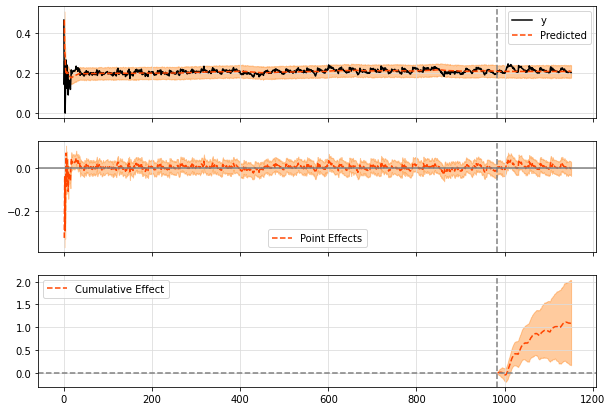

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.22               36.03
Prediction (s.d.)         0.21 (0.0)         34.95 (0.48)
95% CI                    [0.2, 0.22]        [34.04, 35.91]

Absolute effect (s.d.)    0.01 (0.0)         1.08 (0.48)
95% CI                    [0.0, 0.01]        [0.12, 1.99]

Relative effect (s.d.)    3.08% (1.36%)      3.08% (1.36%)
95% CI                    [0.35%, 5.68%]     [0.35%, 5.68%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 99.0%

For more details run the command: print(impact.summary('report'))
The probability of obtaining this effect by chance is very small
(Bayesian one-sided tail-area probability p = 0.01).
This means the causal effect can be considered statistically
significant.


In [5]:
#Тестируем изменение метрики CTR
get_causal_effect(query = metrics['CTR'], start_date = start_date)

### CTR 
<b>Метрика показала стазначимое изменение. Хотя все значения, кроме накопительного значения фактических данных, попадают в 95% доверительный интервал. Сочетание отчета и вывода вводит в заблуждение.</b>

2024-04-10 20:38:34.612693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-04-10 20:38:34.634597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-04-10 20:38:35.454052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-04-10 20:

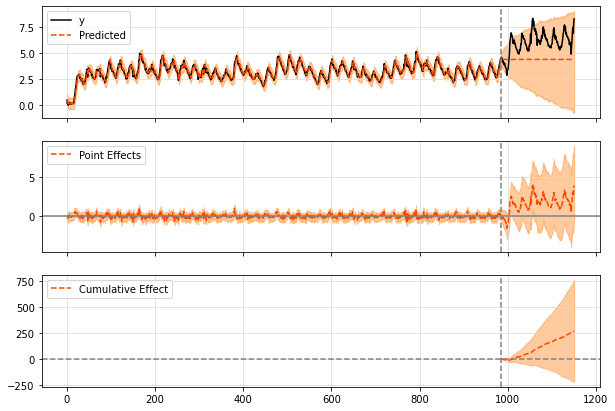

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    6.01               1003.15
Prediction (s.d.)         4.39 (1.4)         732.83 (234.06)
95% CI                    [1.51, 7.0]        [251.42, 1168.93]

Absolute effect (s.d.)    1.62 (1.4)         270.32 (234.06)
95% CI                    [-0.99, 4.5]       [-165.78, 751.74]

Relative effect (s.d.)    36.89% (31.94%)    36.89% (31.94%)
95% CI                    [-22.62%, 102.58%] [-22.62%, 102.58%]

Posterior tail-area probability p: 0.13
Posterior prob. of a causal effect: 86.71%

For more details run the command: print(impact.summary('report'))
The probability of obtaining this effect by chance is p = 13.29%.
This means the effect may be spurious and would generally not be
considered statistically significant.


In [6]:
get_causal_effect(query = metrics['likes per user'], start_date = start_date)

### Likes per user
<b>Метрика не показала статзначимое изменение, хотя график более явно свидетельствует об изменениях, чем в CTR.</b>

2024-04-10 20:44:12.227600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-04-10 20:44:12.251495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-04-10 20:44:12.775835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-04-10 20:

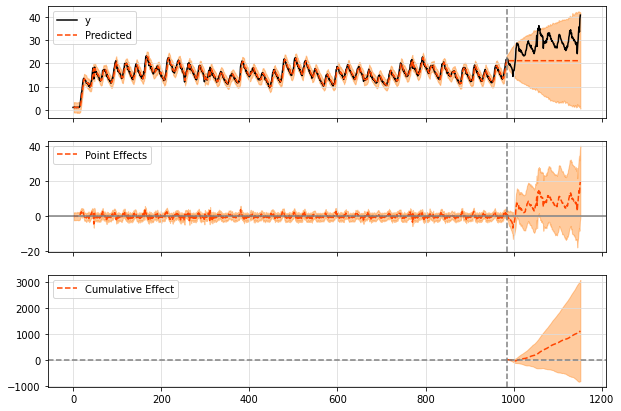

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    27.8               4643.09
Prediction (s.d.)         21.12 (6.1)        3526.68 (1018.59)
95% CI                    [9.79, 33.7]       [1635.27, 5628.06]

Absolute effect (s.d.)    6.69 (6.1)         1116.41 (1018.59)
95% CI                    [-5.9, 18.01]      [-984.97, 3007.81]

Relative effect (s.d.)    31.66% (28.88%)    31.66% (28.88%)
95% CI                    [-27.93%, 85.29%]  [-27.93%, 85.29%]

Posterior tail-area probability p: 0.14
Posterior prob. of a causal effect: 86.21%

For more details run the command: print(impact.summary('report'))
The probability of obtaining this effect by chance is p = 13.79%.
This means the effect may be spurious and would generally not be
considered statistically significant.


In [8]:
get_causal_effect(query = metrics['views per user'], start_date = start_date)

### Views per user
<b>Метрика не показала статзначимое изменение, хотя график более явно свидетельствует об изменениях, чем в CTR.</b>

2024-04-10 20:48:27.580695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-04-10 20:48:27.603519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-04-10 20:48:28.125270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-04-10 20:

2024-04-10 20:49:58.580439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2024-04-10 20:49:58.653796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

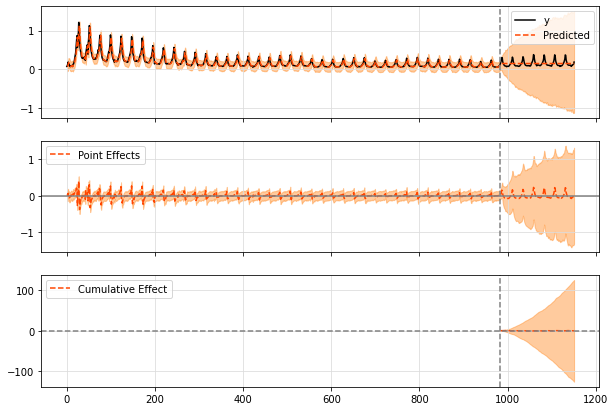

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.14               24.15
Prediction (s.d.)         0.15 (0.37)        24.48 (61.69)
95% CI                    [-0.62, 0.83]      [-103.03, 138.78]

Absolute effect (s.d.)    -0.0 (0.37)        -0.33 (61.69)
95% CI                    [-0.69, 0.76]      [-114.63, 127.18]

Relative effect (s.d.)    -1.36% (251.98%)   -1.36% (251.98%)
95% CI                    [-468.26%, 519.5%] [-468.26%, 519.5%]

Posterior tail-area probability p: 0.49
Posterior prob. of a causal effect: 50.65%

For more details run the command: print(impact.summary('report'))
The probability of obtaining this effect by chance is p = 49.35%.
This means the effect may be spurious and would generally not be
considered statistically significant.


In [9]:
get_causal_effect(query = metrics['posts per user'], start_date = start_date)

### Posts per user
<b>Метрика не показала статзначимое изменение</b>

2024-04-10 20:51:05.340862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-04-10 20:51:05.366399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-04-10 20:51:05.892490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-04-10 20:

2024-04-10 20:51:18.076246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2024-04-10 20:51:18.151361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

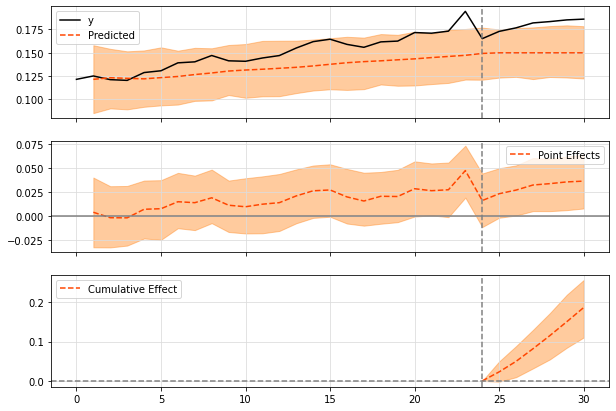

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.18               1.09
Prediction (s.d.)         0.15 (0.01)        0.9 (0.04)
95% CI                    [0.14, 0.16]       [0.82, 0.97]

Absolute effect (s.d.)    0.03 (0.01)        0.19 (0.04)
95% CI                    [0.02, 0.04]       [0.12, 0.26]

Relative effect (s.d.)    20.74% (4.12%)     20.74% (4.12%)
95% CI                    [12.89%, 29.02%]   [12.89%, 29.02%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
The probability of obtaining this effect by chance is very small
(Bayesian one-sided tail-area probability p = 0.0).
This means the causal effect can be considered statistically
significant.


In [10]:
get_causal_effect(query = metrics['stickiness'], start_date = start_date)

### Posts per user
<b>Метрика показала статзначимое изменение. </b>

# Вывод
<b>Суммируя тесты приведённых выше метрик, можно сказать, что флешмоб оказал положительное влияние на CTR (likes/views) и на липкость. Однако нет статистически значимых свидетельств о существенном приросте количества лайков, просмотров и постов на 1 пользователя. <p>Визуализация данных и приводимые цифры в отчете модели сбивают с толку.</b> <p> <i>Личное ощущение: я не понял как это работает...</i>